# Sentiment analysis

### What is sentiment analysis?

In this notebook, we're going to perform [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) on a dataset of tweets about US airlines. Sentiment analysis is the task of extracting [affective states][1] from text. Sentiment analysis is most ofen used to answer questions like:

[1]: https://en.wikipedia.org/wiki/Affect_(psychology)

- _what do our customers think of us?_
- _do our users like the look of our product?_
- _what aspects of our service are users dissatisfied with?_

### Sentiment analysis as text classification

We're going to treat sentiment analysis as a text classification problem. Text classification is just like other instances of classification in data science. We use the term "text classification" when the features come from natural language data. (You'll also hear it called "document classification" at times.) What makes text classification interestingly different from other instances of classification is the way we extract numerical features from text. 

### Dataset

The dataset was collected by [Crowdflower](https://www.crowdflower.com/), which they then made public through [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). I've downloaded it for you and put it in the "data" directory. Note that this is a nice clean dataset; not the norm in real-life data science! I've chosen this dataset so that we can concentrate on understanding what text classification is and how to do it.

### Topics

Here's what we'll cover in our hour. Like any data science task, we'll first do some EDA to understand what data we've got. Then, like always, we'll have to preprocess our data. Because this is text data, it'll be a little different from preprocessing other types of data. Next we'll perform our sentiment classification. Finally, we'll interpret the results of the classifier in terms of our big question.

We'll cover:

[EDA](#eda)<br>

[Preprocess](#preprocess)<br>

[Classification](#classification)<br>

[Interpret](#interpret)<br>

### Time
- Teaching: 30 minutes
- Exercises: 30 minutes

### Final note

Don't worry if you don't follow every single step in our hour. If things are moving too quickly, concentrate on the big picture. Afterwards, you can go through the notebook line by line to understand all the details.

In [1]:
%matplotlib inline
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
sns.set()

## EDA <a id='eda'></a>

In [2]:
DATA_DIR = '../data'
fname = os.path.join(DATA_DIR, 'tweets.csv')
df = pd.read_csv(fname)
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


Which airlines are tweeted about and how many of each in this dataset?

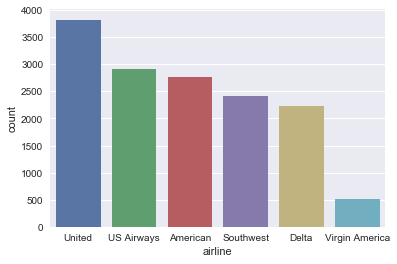

In [3]:
sns.countplot(df['airline'], order=df['airline'].value_counts().index);

### Challenge

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- Visualize these last two questions.

In [4]:
print("Length is", len(df))

Length is 14640


In [5]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
df['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

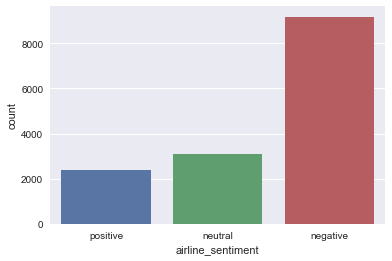

In [7]:
sns.countplot(df['airline_sentiment'], order=['positive', 'neutral', 'negative']);

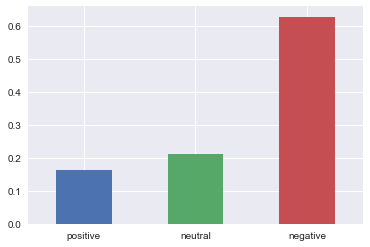

In [8]:
df['airline_sentiment'].value_counts(normalize=True, ascending=True).plot(kind='bar', rot=0);

### Extra challenge

- When did the tweets come from?
- Who gets more retweets: positive, negative or neutral tweets?
- What are the three main reasons why people are tweeting negatively? What could airline companies do to improve this?
- What's the distribution of time zones in which people are tweeting?
- Is this distribution consistent depending on what airlines they're tweeting about?

**All the tweets in this dataset came from the third week of February 2015.**

In [9]:
dates = pd.to_datetime(df['tweet_created'])
print("Year:\n")
print(dates.dt.year.value_counts())
print("Month:\n")
print(dates.dt.month.value_counts())
print("Day:\n")
print(dates.dt.day.value_counts())

Year:

2015    14640
Name: tweet_created, dtype: int64
Month:

2    14640
Name: tweet_created, dtype: int64
Day:

23    3515
22    2392
24    2136
20    1512
21    1418
18    1416
19    1298
17     953
Name: tweet_created, dtype: int64


We don't see any interesting evidence of tweets of different classes getting more or less retweets. The vast majority of tweets from all three classes get no retweets.

In [10]:
df.groupby('airline_sentiment')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
airline_sentiment,,,,,,,,
negative,9178.0,0.093375,0.792865,0.0,0.0,0.0,0.0,44.0
neutral,3099.0,0.060987,0.658037,0.0,0.0,0.0,0.0,28.0
positive,2363.0,0.069403,0.659914,0.0,0.0,0.0,0.0,22.0


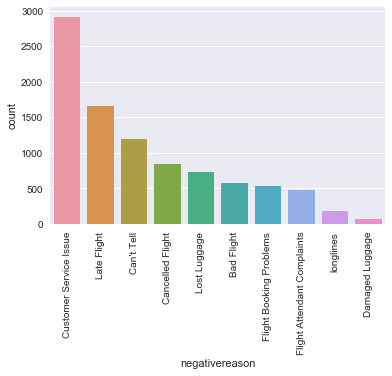

In [11]:
sns.countplot(df['negativereason'], order=df['negativereason'].value_counts().index)
plt.xticks(rotation=90);

## Preprocess  <a id='preprocess'></a>

### Regular expressions

Regular expressions are like advanced find-and-replace. They allow us to specify complicated patterns in text data and find all the matches. They're indispensable in text processing. You can learn more about them [here](https://github.com/geoffbacon/regular-expressions-in-python).

We can use regular expressions to find hashtags and user mentions in a tweet. We first write the pattern we're looking for as a (raw) string, using regular expression's special syntax. The `twitter_handle_pattern` says "find me a @ sign immediately followed by one or more upper or lower case letters, digits or underscore". The `hashtag_pattern` is a little more complicated; it says "find me exactly one ＃ or #, immediately followed by one or more upper or lower case letters, digits or underscore, but only if it's at the beginning of a line or immediately after a whitespace character".

In [12]:
import re
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'
example_tweet = "lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo"

In [13]:
re.findall(twitter_handle_pattern, example_tweet)

['justinbeiber', 'BillGates']

In [14]:
re.findall(hashtag_pattern, example_tweet)

['yesterday', 'amiright', 'yolo']

In [15]:
re.findall(url_pattern, example_tweet)

['https://twitter.com']

`pandas` has great in-built support for operating with regular expressions on columns. We can `extract` all user mentions from a column of text like this:

In [16]:
df['text'].str.extract(twitter_handle_pattern).head(10)

0    VirginAmerica
1    VirginAmerica
2    VirginAmerica
3    VirginAmerica
4    VirginAmerica
5    VirginAmerica
6    VirginAmerica
7    VirginAmerica
8    virginamerica
9    VirginAmerica
Name: text, dtype: object

And find all the hashtags like this:

In [17]:
df['text'].str.extract(hashtag_pattern).head(20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13      fabulous
14           NaN
15           NaN
16    29DaysToGo
17           NaN
18           NaN
19           NaN
Name: text, dtype: object

### Challenge

Often in preprocessing text data, we don't care about the exact hashtag/user/URL that someone used (although sometimes we do!). Your job is to replace all the hashtags with `'HASHTAG'`, the user mentions with `'USER'` and URLs with `'URL'`. To do this, you'll use the `replace` string method of the `text` column. The result of this will be a series, which you should add to `df` as a column called `clean_text`. **See the docs [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) for more information on the method.**

In [18]:
df['clean_text'] = (df['text']
                    .str.replace(hashtag_pattern, 'HASHTAG')
                    .str.replace(twitter_handle_pattern, 'USER')
                    .str.replace(url_pattern, 'URL')
                              )
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),USER What USER said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),USER plus you've added commercials to the expe...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),USER I didn't today... Must mean I need to tak...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),USER it's really aggressive to blast obnoxious...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),USER and it's a really big bad thing about it


### Bag of words

Now that we've cleaned the text, we need to turn the text into numbers for our classifier. We're going to use a "bag of words" as our features. A bag of words is just like a frequency count of all the words that appear in a tweet. It's called a bag because we ignore the order of the words; we just care about what words are in the tweet. To do this, we can use `scikit-learn`'s `CountVectorizer`. `CountVectorizer` replaces each tweet with a vector (think a list) of counts. Each position in the vector represents a unique word in the corpus. The value of an entry in a vector represents the number of times that word appeared in that tweet. Below, we restrict the length of the vectors to be 5,000 and the counts to be 0 (not in the tweet) and 1 (in the tweet).

In [19]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df['clean_text'])
features = X.toarray()
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
response = df['airline_sentiment'].values
response

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

### Split into train/test datasets

We don't want to train our classifier on the same dataset that we test it on, so let's split it into training and test sets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2)

## Classification  <a id='classification'></a>

OK, so now that we've turned our data into numbers, we're ready to feed it into a classifier. We're not going to concentrate too much on the code below, but here's the big picture. In the `fit_model` function defined below, we're going to use logistic regression as a classifier to take in the numerical representation of the tweets and spit out whether it's positive, neutral or negative. Then we'll use `test_model` to test the model's performance against our test data and print out some results.

In [22]:
def fit_logistic_regression(X_train, y_train):
    model = LogisticRegressionCV(Cs=5, penalty='l1', cv=3, solver='liblinear', refit=True)
    model.fit(X_train, y_train)
    return model

def conmat(model, X_test, y_test):
    """Wrapper for sklearn's confusion matrix."""
    labels = model.classes_
    y_pred = model.predict(X_test)
    c = confusion_matrix(y_test, y_pred)
    sns.heatmap(c, annot=True, fmt='d', 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="YlGnBu", cbar=False)
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')
    
def test_model(model, X_train, y_train):
    conmat(model, X_test, y_test)
    print('Accuracy: ', model.score(X_test, y_test))

In [23]:
lr = fit_logistic_regression(X_train, y_train)

Accuracy:  0.787568306010929


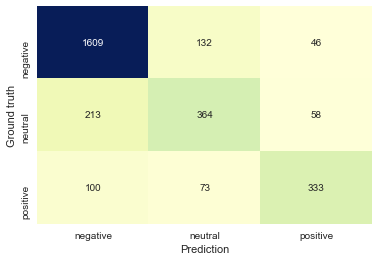

In [24]:
test_model(lr, X_test, y_test)

### Challenge

Use the `fit_random_forest` function below to train a random forest classifier on the training set and test the model on the test set. Which performs better?

In [25]:
def fit_random_forest(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

Accuracy:  0.7189207650273224


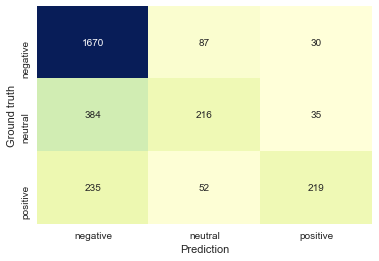

In [26]:
rf = fit_random_forest(X_train, y_train)
test_model(rf, X_test, y_test)

### Challenge

Use the `test_tweet` function below to test your classifier's performance on a list of tweets. Write your tweets 

In [27]:
def clean_tweets(tweets):
    tweets = [re.sub(hashtag_pattern, 'HASHTAG', t) for t in tweets]
    tweets = [re.sub(twitter_handle_pattern, 'USER', t) for t in tweets]
    return [re.sub(url_pattern, 'URL', t) for t in tweets]

def test_tweets(tweets, model):
    tweets = clean_tweets(tweets)
    features = countvectorizer.transform(tweets)
    predictions = model.predict(features)
    return list(zip(tweets, predictions))

In [28]:
my_tweets = [example_tweet,
            'omg I am never flying on Delta again',
            'I love @VirginAmerica so much #friendlystaff']

test_tweets(my_tweets, lr)

[('lol USER and USER are like sooHASHTAGHASHTAG saw it on URLHASHTAG',
  'neutral'),
 ('omg I am never flying on Delta again', 'negative'),
 ('I love USER so muchHASHTAG', 'positive')]

## Interpret <a id='interpret'></a>

Now we can interpret the classifier by the features that it found important.

In [29]:
vocab = [(v,k) for k,v in countvectorizer.vocabulary_.items()]
vocab = sorted(vocab, key=lambda x: x[0])
vocab = [word for num,word in vocab]
coef = list(zip(vocab, lr.coef_[0]))
important = pd.DataFrame(lr.coef_).T
important.columns = lr.classes_
important['word'] = vocab
important.head()

,negative,neutral,positive,word
0,0.512289,-1.525984,0.000000,00
1,0.000000,0.000000,0.771386,000
2,0.000000,0.000000,0.000000,00pm
3,0.000000,0.000000,0.000000,02
4,0.000000,0.000000,0.000000,03


In [30]:
important.sort_values(by='negative', ascending=False).head(10)

,negative,neutral,positive,word
4946,4.694786,-3.095330,-3.453707,worst
3787,3.438249,-2.440995,-0.882528,ridiculous
4164,3.063764,-0.433349,-2.605314,solution
4728,2.897389,-0.468029,0.000000,unless
1927,2.818232,-1.073857,-1.047555,forced
4945,2.742792,-1.927148,-0.937471,worse
963,2.708912,0.000000,-1.837692,canned
896,2.684064,-1.910408,-1.730003,broken
4336,2.610787,-1.974351,-1.489708,suck
4449,2.609187,-1.583526,-1.610608,terrible


In [31]:
important.sort_values(by='positive', ascending=False).head(10)

,negative,neutral,positive,word
1680,-2.102169,-1.459683,4.249632,excellent
3396,-2.096573,0.000000,4.039231,pleasure
4929,-2.985894,-0.422768,3.874721,wonderful
4943,-3.706279,0.554710,3.791824,worries
1683,-1.989573,0.000000,3.575411,exceptional
2620,-2.089720,-0.903687,3.557128,kudos
1764,-1.681557,-0.939312,3.475118,fantastic
4462,-2.799422,-1.145404,3.360149,thank
711,-2.146466,-1.693583,3.333522,awesome
4463,-2.269361,0.000000,3.323844,thankful
